In [ ]:
# ============================================================
# Traffic Sign Recognition (Data Mining Project)
# BITS Pilani Dubai Campus
# Authors: Irene Maria Varghese, Aroosh Ahmed, Vaishnavi Bansal
# ============================================================

# 1. IMPORTS & SETTINGS
import os, zipfile, cv2, numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    silhouette_score, davies_bouldin_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN, SpectralClustering

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2

# SAFE MODE SETTINGS
IMG_SIZE = (64, 64)
BATCH_SIZE = 32
EPOCHS = 15
RANDOM_STATE = 42

EXTRACT_PATH = "/content/gtsrb_data"
ZIP_PATH = "/content/drive/MyDrive/GTSRB/archive.zip"


In [ ]:
# 2. LOAD DATASET & PREPROCESSING
drive.mount('/content/drive')

if not os.path.exists(EXTRACT_PATH):
    print("Extracting dataset ... ")
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_PATH)
else:
    print("Dataset already extracted.")

TRAIN_CSV = os.path.join(EXTRACT_PATH, "Train.csv")

def load_image(path, img_size=IMG_SIZE):
    img = cv2.imread(path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_size)
    return img.astype(np.float32) / 255.0

def preprocess_csv(csv_path):
    df = pd.read_csv(csv_path)
    X, y = [], []
    print(f"Processing {csv_path} ... ")
    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = os.path.join(EXTRACT_PATH, row["Path"])
        img = load_image(img_path)
        if img is not None:
            X.append(img)
            y.append(int(row["ClassId"]))
    return np.array(X), np.array(y)

X_all, y_all = preprocess_csv(TRAIN_CSV)

X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, stratify=y_all, random_state=RANDOM_STATE
)

print("Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)


Mounted at /content/drive
Extracting dataset ... 
Processing /content/gtsrb_data/Train.csv ... 


100%|██████████| 39209/39209 [00:27<00:00, 1420.90it/s]


Shapes:
X_train: (31367, 64, 64, 3)
X_test: (7842, 64, 64, 3)


In [ ]:
# --- Check dataset split sizes ---
print("Full dataset size:", len(X_all))
print("Train set size (80%):", len(X_train))
print("Test set size (20%):", len(X_test))

# --- Check Safe Mode subsample sizes ---
print("Safe Mode train subset size:", len(X_train_small))
print("Safe Mode test subset size:", len(X_test_small))


Full dataset size: 39209
Train set size (80%): 31367
Test set size (20%): 7842
Safe Mode train subset size: 5000
Safe Mode test subset size: 1000


Training Decision Tree ...


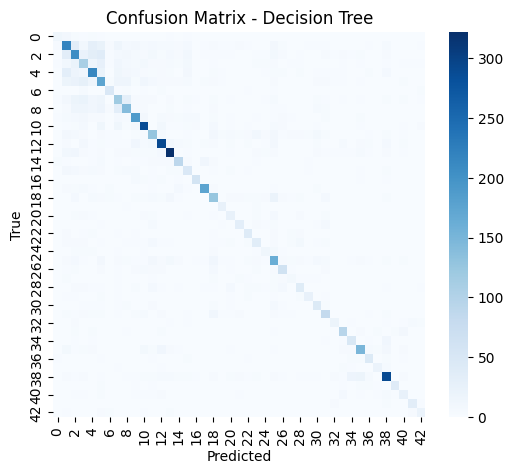

Training KNN ...


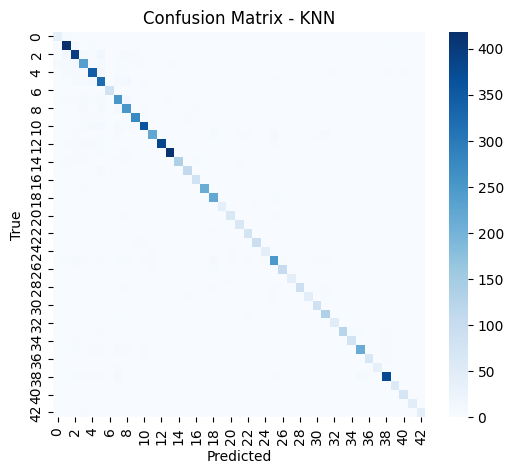

Training Naive Bayes ...


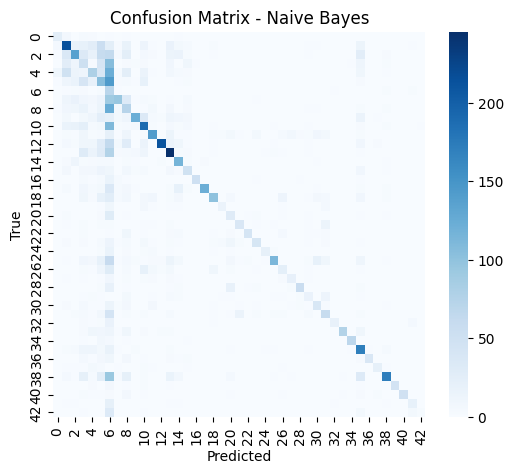

Training SVM (Linear) ...


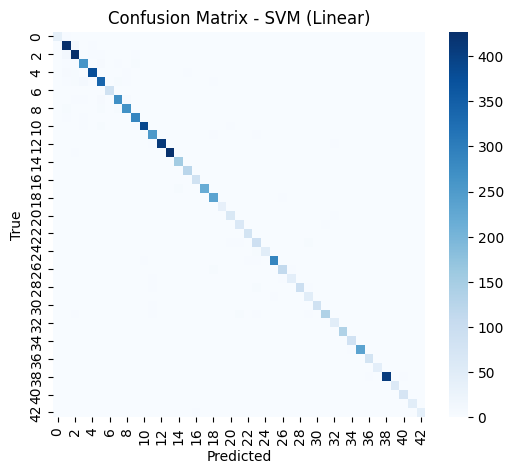

=== CLASSICAL BASELINE RESULTS (with PCA) ===
               Accuracy  Precision  Recall  F1-Score
Decision Tree    0.5520     0.5134  0.5119    0.5118
KNN              0.8952     0.9097  0.8968    0.9018
Naive Bayes      0.4336     0.6511  0.4612    0.5104
SVM (Linear)     0.9545     0.9447  0.9480    0.9455


In [ ]:
# 3. CLASSICAL ML MODELS (with PCA preprocessing)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_flat)
X_test_std = scaler.transform(X_test_flat)

pca = PCA(n_components=150, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

models = {
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "SVM (Linear)": SVC(kernel='linear', random_state=RANDOM_STATE)
}

results_classical = {}
for name, model in models.items():
    print(f"Training {name} ...")
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    results_classical[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='macro', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='macro', zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, average='macro', zero_division=0)
    }
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, cmap="Blues", annot=False, cbar=True)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

df_classical = pd.DataFrame(results_classical).T
print("=== CLASSICAL BASELINE RESULTS (with PCA) ===")
print(df_classical.round(4))


In [ ]:
# 4. CNN (Proposed Method)
X_train_small = X_train[:5000]
y_train_small = y_train[:5000]
X_test_small = X_test[:1000]
y_test_small = y_test[:1000]

datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08
)
datagen.fit(X_train_small)

cnn_model = Sequential([
    tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(y_train_small)), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

history_cnn = cnn_model.fit(
    datagen.flow(X_train_small, y_train_small, batch_size=16),
    validation_data=(X_test_small, y_test_small),
    epochs=20,
    callbacks=callbacks,
    verbose=2
)

y_pred_cnn = np.argmax(cnn_model.predict(X_test_small, batch_size=16), axis=1)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
313/313 - 66s - 212ms/step - accuracy: 0.0804 - loss: 3.8784 - val_accuracy: 0.1020 - val_loss: 14.6175 - learning_rate: 1.0000e-03
Epoch 2/20
313/313 - 52s - 165ms/step - accuracy: 0.1156 - loss: 3.5057 - val_accuracy: 0.1640 - val_loss: 4.2443 - learning_rate: 1.0000e-03
Epoch 3/20
313/313 - 49s - 158ms/step - accuracy: 0.1264 - loss: 3.3346 - val_accuracy: 0.1800 - val_loss: 3.0372 - learning_rate: 1.0000e-03
Epoch 4/20
313/313 - 51s - 164ms/step - accuracy: 0.1344 - loss: 3.2356 - val_accuracy: 0.2600 - val_loss: 2.8491 - learning_rate: 1.0000e-03
Epoch 5/20
313/313 - 50s - 158ms/step - accuracy: 0.1662 - loss: 3.1429 - val_accuracy: 0.3000 - val_loss: 2.7059 - learning_rate: 1.0000e-03
Epoch 6/20
313/313 - 85s - 272ms/step - accuracy: 0.1802 - loss: 3.1006 - val_accuracy: 0.2790 - val_loss: 2.6713 - learning_rate: 1.0000e-03
Epoch 7/20
313/313 - 78s - 250ms/step - accuracy: 0.1842 - loss: 2.9977 - val_accuracy: 0.2880 - val_loss: 2.5487 - learning_rate: 1.0000e-03
Epoch

In [ ]:
# 5. MobileNetV2 (Transfer Learning)
base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')
for layer in base_model.layers[:-20]:
    layer.trainable = False

mobilenet_model = Sequential([
    tf.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train_small)), activation='softmax')
])

mobilenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_mobilenet = mobilenet_model.fit(
    datagen.flow(X_train_small, y_train_small, batch_size=16),
    validation_data=(X_test_small, y_test_small),
    epochs=20,
    callbacks=callbacks,
    verbose=2
)

y_pred_mobilenet = np.argmax(mobilenet_model.predict(X_test_small, batch_size=16), axis=1)


/tmp/ipython-input-4286495483.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
313/313 - 56s - 179ms/step - accuracy: 0.3264 - loss: 2.4908 - val_accuracy: 0.2670 - val_loss: 4.2323 - learning_rate: 1.0000e-03
Epoch 2/20
313/313 - 37s - 120ms/step - accuracy: 0.4444 - loss: 1.8724 - val_accuracy: 0.3800 - val_loss: 3.9582 - learning_rate: 1.0000e-03
Epoch 3/20
313/313 - 42s - 134ms/step - accuracy: 0.5088 - loss: 1.6018 - val_accuracy: 0.3910 - val_loss: 2.1874 - learning_rate: 1.0000e-03
Epoch 4/20
313/313 - 36s - 116ms/step - accuracy: 0.5762 - loss: 1.3631 - val_accuracy: 0.4720 - val_loss: 2.3854 - learning_rate: 1.0000e-03
Epoch 5/20

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
313/313 - 39s - 125ms/step - accuracy: 0.6086 - loss: 1.2416 - val_accuracy: 0.4180 - val_loss: 3.3744 - learning_rate: 1.0000e-03
Epoch 6/20
313/313 - 38s - 120ms/step - accuracy: 0.6850 - loss: 0.9757 - val_accuracy: 0.6050 - val_loss: 1.5961 - learning_rate: 5.0000e-04
Epoch 7/20
313/313 - 3

=== FINAL COMPARISON RESULTS ===
                          Accuracy  Precision  Recall  F1-Score
Decision Tree               0.5520     0.5134  0.5119    0.5118
KNN                         0.8952     0.9097  0.8968    0.9018
Naive Bayes                 0.4336     0.6511  0.4612    0.5104
SVM (Linear)                0.9545     0.9447  0.9480    0.9455
Improved CNN                0.4780     0.2852  0.3037    0.2625
MobileNetV2 (Pretrained)    0.8600     0.8596  0.8258    0.8262


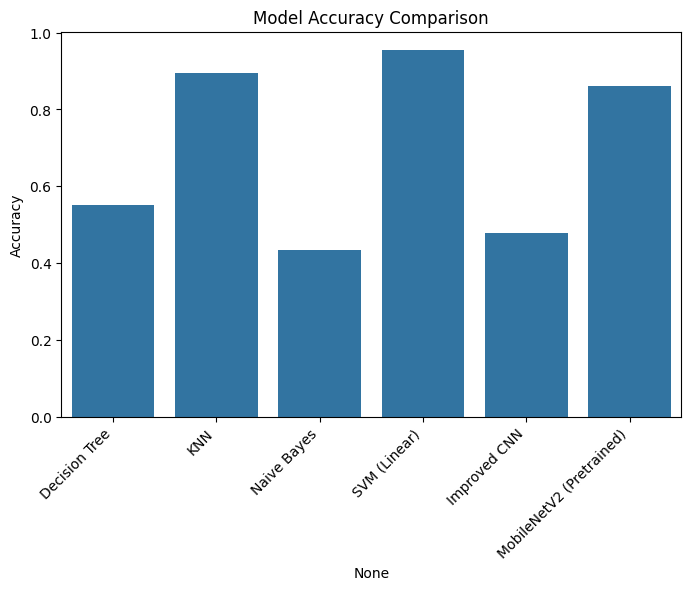

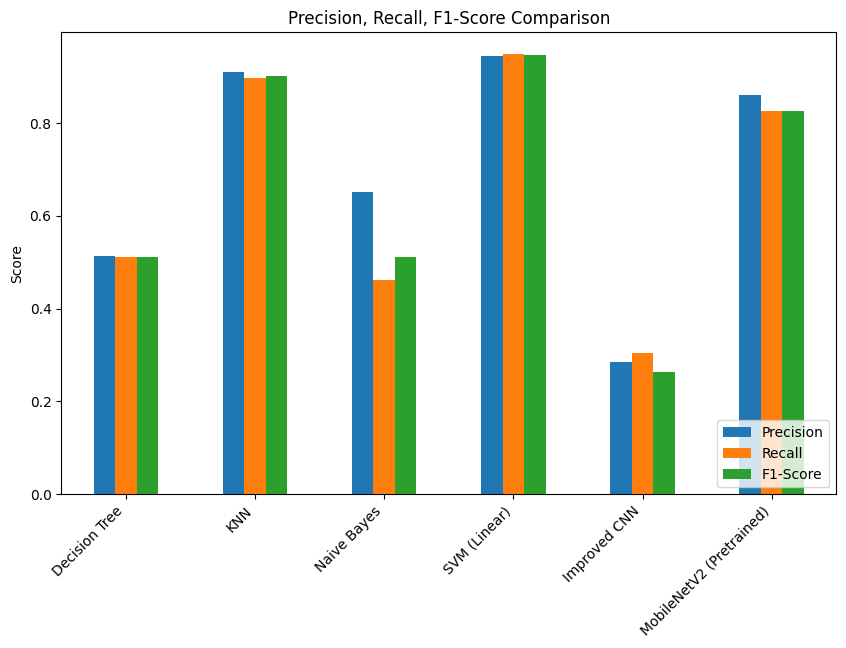

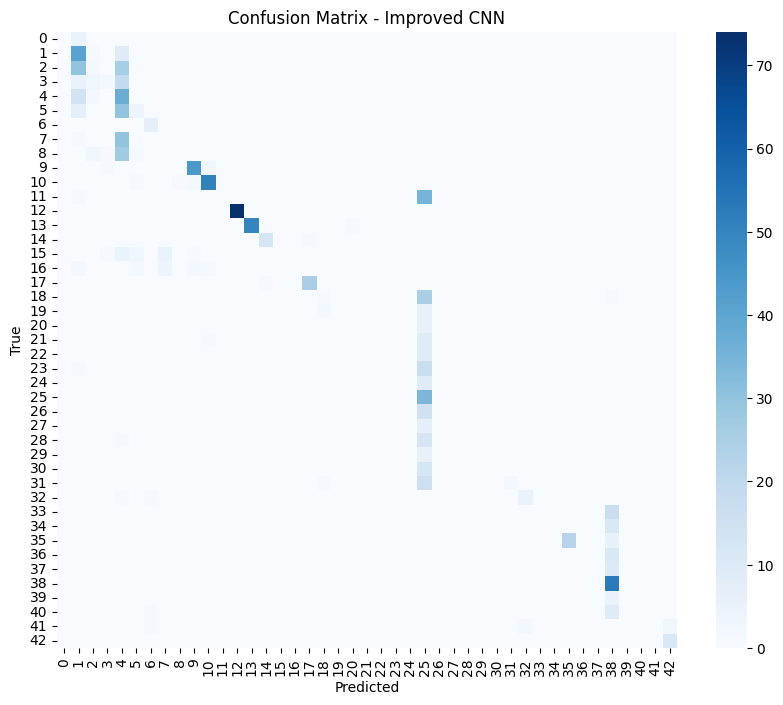

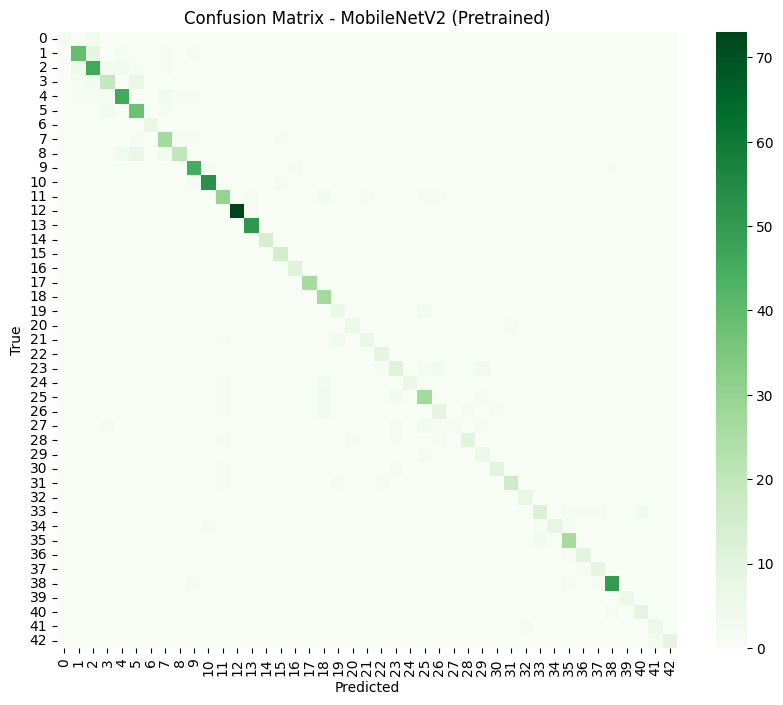

In [ ]:
# 6. EVALUATION & RESULTS
results_all = {}
for model_name in df_classical.index:
    results_all[model_name] = df_classical.loc[model_name].to_dict()

# --- CNN results ---
results_all["Improved CNN"] = {
    "Accuracy": accuracy_score(y_test_small, y_pred_cnn),
    "Precision": precision_score(y_test_small, y_pred_cnn, average='macro', zero_division=0),
    "Recall": recall_score(y_test_small, y_pred_cnn, average='macro', zero_division=0),
    "F1-Score": f1_score(y_test_small, y_pred_cnn, average='macro', zero_division=0)
}

# --- MobileNetV2 results ---
results_all["MobileNetV2 (Pretrained)"] = {
    "Accuracy": accuracy_score(y_test_small, y_pred_mobilenet),
    "Precision": precision_score(y_test_small, y_pred_mobilenet, average='macro', zero_division=0),
    "Recall": recall_score(y_test_small, y_pred_mobilenet, average='macro', zero_division=0),
    "F1-Score": f1_score(y_test_small, y_pred_mobilenet, average='macro', zero_division=0)
}

# Convert to DataFrame for clean display
df_results = pd.DataFrame(results_all).T
print("=== FINAL COMPARISON RESULTS ===")
print(df_results.round(4))

# --- Accuracy Bar Chart ---
plt.figure(figsize=(8,5))
sns.barplot(x=df_results.index, y=df_results["Accuracy"])
plt.xticks(rotation=45, ha="right")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

# --- Grouped Metrics Bar Chart ---
df_metrics = df_results[["Precision", "Recall", "F1-Score"]]
df_metrics.plot(kind="bar", figsize=(10,6))
plt.title("Precision, Recall, F1-Score Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="lower right")
plt.show()

# --- Confusion Matrix: CNN ---
cm_cnn = confusion_matrix(y_test_small, y_pred_cnn)
plt.figure(figsize=(10,8))
sns.heatmap(cm_cnn, cmap="Blues", annot=False, cbar=True)
plt.title("Confusion Matrix - Improved CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Confusion Matrix: MobileNetV2 ---
cm_mobilenet = confusion_matrix(y_test_small, y_pred_mobilenet)
plt.figure(figsize=(10,8))
sns.heatmap(cm_mobilenet, cmap="Greens", annot=False, cbar=True)
plt.title("Confusion Matrix - MobileNetV2 (Pretrained)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Running KMeans ...
Running MiniBatchKMeans ...
Running Agglomerative ...
Running DBSCAN ...
Running Spectral ...
=== SAFE MODE CLUSTERING RESULTS ===
                 Silhouette  Davies-Bouldin    Dunn         WCSS
KMeans               0.1885          1.6815  0.0318  408265.4375
MiniBatchKMeans      0.1648          1.8471  0.0276  422378.0312
Agglomerative        0.1541          1.7529  0.0353          NaN
DBSCAN              -0.1882          1.4079  0.0158          NaN
Spectral             0.0288          1.4951  0.0074          NaN


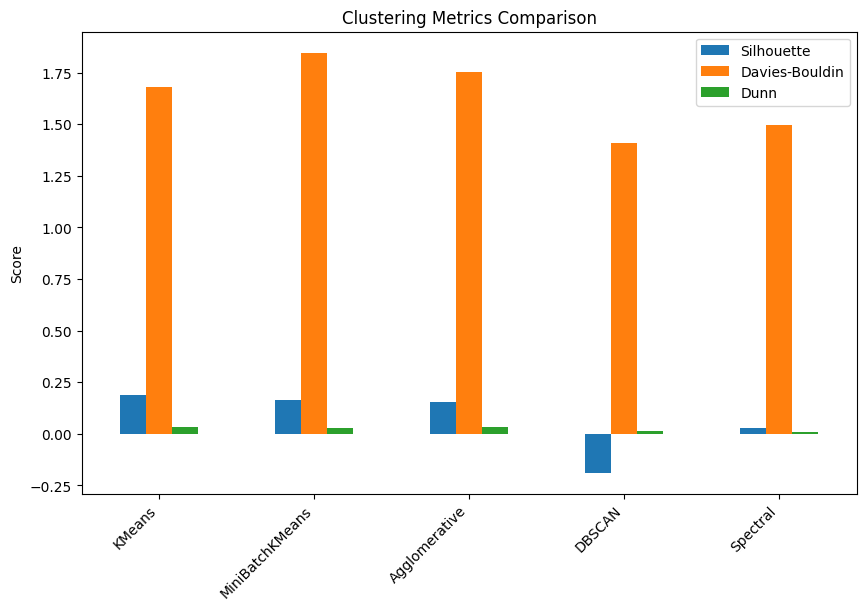

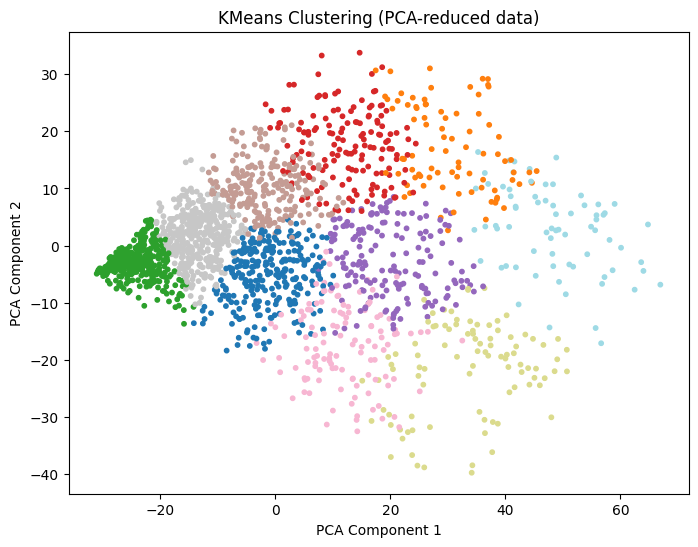

In [ ]:
# 7. CLUSTERING METHODS (Safe Mode with PCA reduction)
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# Subsample for lighter clustering
X_cluster_small = X_train_flat[:2000]

# Reduce dimensionality
pca_cluster = PCA(n_components=15, random_state=RANDOM_STATE)
X_cluster_small = pca_cluster.fit_transform(X_cluster_small)

# --- Dunn Index function ---
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    if len(unique_clusters) < 2:
        return 0
    diameters = []
    for c in unique_clusters:
        points = X[labels == c]
        if len(points) > 1:
            diameters.append(np.max(np.linalg.norm(points[:, None] - points, axis=2)))
    max_diameter = max(diameters) if diameters else 1
    min_inter = np.inf
    for i in range(len(unique_clusters)):
        for j in range(i+1, len(unique_clusters)):
            ci = X[labels == unique_clusters[i]]
            cj = X[labels == unique_clusters[j]]
            dist = np.min(np.linalg.norm(ci[:, None] - cj, axis=2))
            min_inter = min(min_inter, dist)
    return min_inter / max_diameter

# --- WCSS function ---
def wcss(X, labels, centroids):
    return sum(np.sum((X[labels == i] - centroids[i]) ** 2) for i in range(len(centroids)))

# Clustering models (includes Spectral for Graph-based)
cluster_models = {
    "KMeans": KMeans(n_clusters=10, random_state=RANDOM_STATE, n_init=10),
    "MiniBatchKMeans": MiniBatchKMeans(n_clusters=10, random_state=RANDOM_STATE, batch_size=256),
    "Agglomerative": AgglomerativeClustering(n_clusters=10),
    "DBSCAN": DBSCAN(eps=3, min_samples=5),
    "Spectral": SpectralClustering(n_clusters=10, random_state=RANDOM_STATE, affinity='nearest_neighbors')
}

results_cluster = {}
labels_dict = {}

for name, model in cluster_models.items():
    print(f"Running {name} ...")
    try:
        y_pred_cluster = model.fit_predict(X_cluster_small)
        labels_dict[name] = y_pred_cluster
        sil = silhouette_score(X_cluster_small, y_pred_cluster)
        dbi = davies_bouldin_score(X_cluster_small, y_pred_cluster)
        di = dunn_index(X_cluster_small, y_pred_cluster)
        if hasattr(model, "cluster_centers_"):
            wcss_val = wcss(X_cluster_small, y_pred_cluster, model.cluster_centers_)
        else:
            wcss_val = None
        results_cluster[name] = {
            "Silhouette": sil,
            "Davies-Bouldin": dbi,
            "Dunn": di,
            "WCSS": wcss_val
        }
    except Exception as e:
        results_cluster[name] = {"Silhouette": None, "Davies-Bouldin": None, "Dunn": None, "WCSS": None}
        print(f"{name} failed: {e}")

df_cluster = pd.DataFrame(results_cluster).T
print("=== SAFE MODE CLUSTERING RESULTS ===")
print(df_cluster.round(4))

# --- Graph 1: Bar chart of metrics ---
df_metrics = df_cluster[["Silhouette", "Davies-Bouldin", "Dunn"]]
df_metrics.plot(kind="bar", figsize=(10, 6))
plt.title("Clustering Metrics Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.show()

# --- Graph 2: PCA scatter plot for KMeans ---
plt.figure(figsize=(8,6))
plt.scatter(X_cluster_small[:, 0], X_cluster_small[:, 1], c=labels_dict["KMeans"], cmap="tab20", s=10)
plt.title("KMeans Clustering (PCA-reduced data)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()


=== CLASSIFICATION RESULTS ===
                          Accuracy  Precision  Recall  F1-Score
Decision Tree               0.5520     0.5134  0.5119    0.5118
KNN                         0.8952     0.9097  0.8968    0.9018
Naive Bayes                 0.4336     0.6511  0.4612    0.5104
SVM (Linear)                0.9545     0.9447  0.9480    0.9455
Improved CNN                0.4780     0.2852  0.3037    0.2625
MobileNetV2 (Pretrained)    0.8600     0.8596  0.8258    0.8262

=== CLUSTERING RESULTS ===
                 Silhouette  Davies-Bouldin    Dunn         WCSS
KMeans               0.1885          1.6815  0.0318  408265.4375
MiniBatchKMeans      0.1648          1.8471  0.0276  422378.0312
Agglomerative        0.1541          1.7529  0.0353          NaN
DBSCAN              -0.1882          1.4079  0.0158          NaN
Spectral             0.0288          1.4951  0.0074          NaN


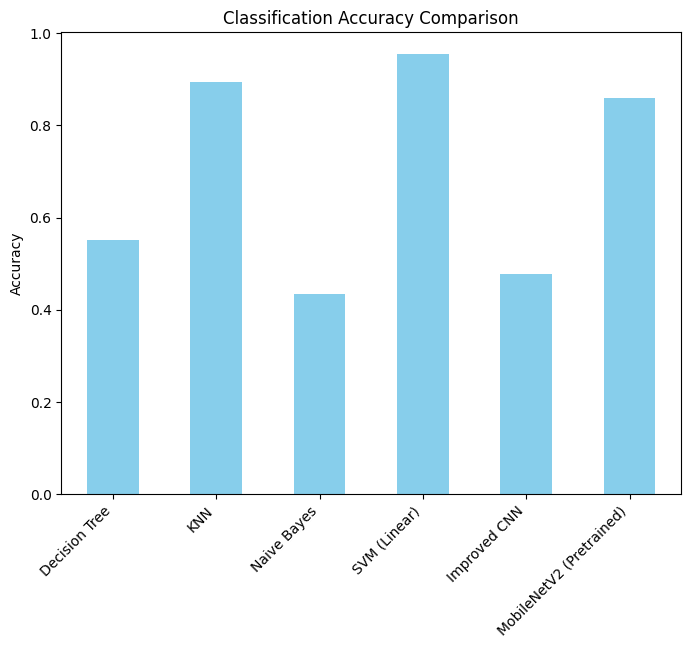

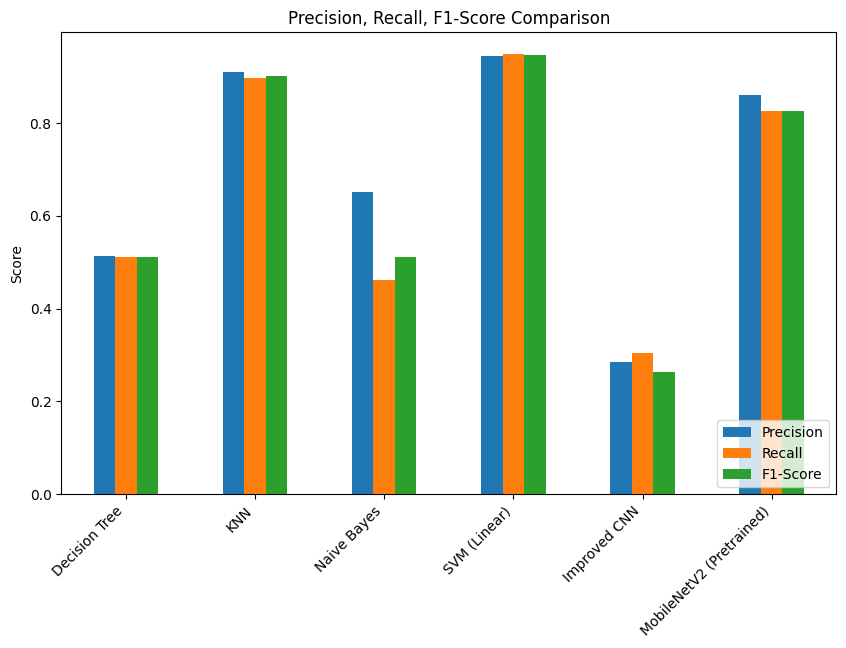

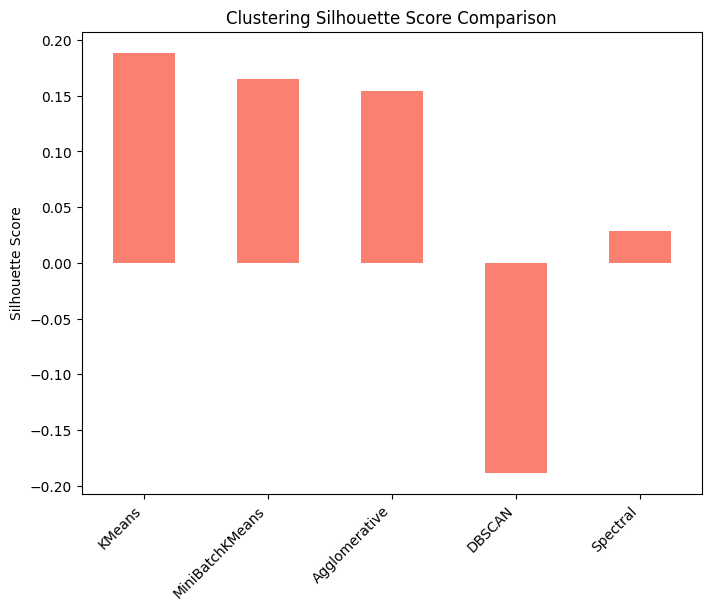

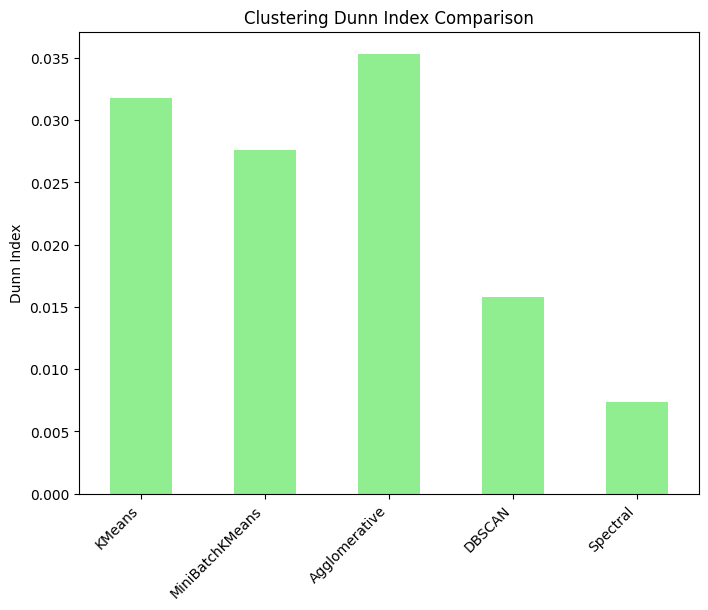

In [ ]:
# 8. FINAL SUMMARY: Classification + Clustering

# --- Classification results ---
print("=== CLASSIFICATION RESULTS ===")
print(df_results.round(4))   # df_results from Cell 6

# --- Clustering results ---
print("\n=== CLUSTERING RESULTS ===")
print(df_cluster.round(4))   # df_cluster from Cell 7

# --- Graph 1: Classification Accuracy Comparison ---
plt.figure(figsize=(8,6))
df_results["Accuracy"].plot(kind="bar", color="skyblue")
plt.title("Classification Accuracy Comparison")
plt.ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.show()

# --- Graph 2: Classification Metrics Comparison ---
df_results[["Precision", "Recall", "F1-Score"]].plot(kind="bar", figsize=(10,6))
plt.title("Precision, Recall, F1-Score Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="lower right")
plt.show()

# --- Graph 3: Clustering Silhouette Score Comparison ---
plt.figure(figsize=(8,6))
df_cluster["Silhouette"].plot(kind="bar", color="salmon")
plt.title("Clustering Silhouette Score Comparison")
plt.ylabel("Silhouette Score")
plt.xticks(rotation=45, ha="right")
plt.show()

# --- Graph 4: Clustering Dunn Index Comparison ---
plt.figure(figsize=(8,6))
df_cluster["Dunn"].plot(kind="bar", color="lightgreen")
plt.title("Clustering Dunn Index Comparison")
plt.ylabel("Dunn Index")
plt.xticks(rotation=45, ha="right")
plt.show()


Saving STOP SIGN.jpg to STOP SIGN.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Predicted ClassId: 14
Predicted Sign: Stop


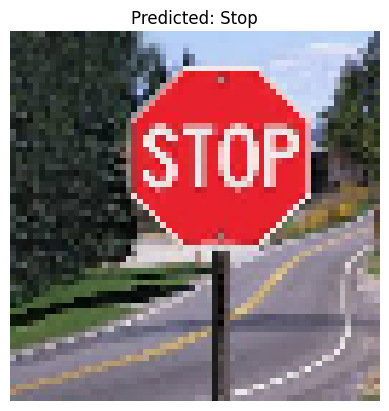

In [ ]:
# === DEMO: Predict a single uploaded image ===
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Upload an image
uploaded = files.upload()

# Step 2: ClassId to label mapping (GTSRB 43 classes)
class_labels = {
    0: "Speed Limit 20 km/h", 1: "Speed Limit 30 km/h", 2: "Speed Limit 50 km/h", 3: "Speed Limit 60 km/h",
    4: "Speed Limit 70 km/h", 5: "Speed Limit 80 km/h", 6: "End of Speed Limit 80 km/h", 7: "Speed Limit 100 km/h",
    8: "Speed Limit 120 km/h", 9: "No passing", 10: "No passing for vehicles over 3.5 tons",
    11: "Right-of-way at the next intersection", 12: "Priority road", 13: "Yield", 14: "Stop",
    15: "No vehicles", 16: "Vehicles over 3.5 tons prohibited", 17: "No entry", 18: "General caution",
    19: "Dangerous curve to the left", 20: "Dangerous curve to the right", 21: "Double curve",
    22: "Bumpy road", 23: "Slippery road", 24: "Road narrows on the right", 25: "Road work",
    26: "Traffic signals", 27: "Pedestrians", 28: "Children crossing", 29: "Bicycles crossing",
    30: "Beware of ice/snow", 31: "Wild animals crossing", 32: "End of all restrictions",
    33: "Turn right ahead", 34: "Turn left ahead", 35: "Ahead only", 36: "Go straight or right",
    37: "Go straight or left", 38: "Keep right", 39: "Keep left", 40: "Roundabout mandatory",
    41: "End of no passing", 42: "End of no passing for vehicles over 3.5 tons"
}

# Step 3: Preprocess and predict
for filename in uploaded.keys():
    img = load_image(filename, img_size=IMG_SIZE)   # reuse your load_image function
    img_input = np.expand_dims(img, axis=0)         # add batch dimension

    # Predict using MobileNetV2
    prediction_probs = mobilenet_model.predict(img_input)
    predicted_class = np.argmax(prediction_probs, axis=1)[0]
    predicted_label = class_labels.get(predicted_class, "Unknown")

    # Show result
    print(f"Predicted ClassId: {predicted_class}")
    print(f"Predicted Sign: {predicted_label}")

    # Optional: Display image with prediction
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()
